# Early Stopping with MLJFlux

In this workflow example, we learn how MLJFlux enables us to easily use early stopping when training MLJFlux models.

In [1]:
using Pkg
Pkg.activate(@__DIR__);
Pkg.instantiate();

  Activating project at `~/GoogleDrive/Julia/MLJ/MLJFlux/docs/src/workflow examples/Early Stopping`


**Julia version** is assumed to be 1.10.*

### Basic Imports

In [2]:
using MLJ               # Has MLJFlux models
using Flux              # For more flexibility
import RDatasets        # Dataset source
using Plots             # To visualize training
import Optimisers       # native Flux.jl optimisers no longer supported

### Loading and Splitting the Data

In [3]:
iris = RDatasets.dataset("datasets", "iris");
y, X = unpack(iris, ==(:Species), colname -> true, rng=123);
X = Float32.(X);      # To be compatible with type of network network parameters

### Instantiating the model Now let's construct our model. This follows a similar setup
to the one followed in the [Quick Start](../../index.md#Quick-Start).

In [4]:
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg=MLJFlux

clf = NeuralNetworkClassifier(
    builder=MLJFlux.MLP(; hidden=(5,4), σ=Flux.relu),
    optimiser=Optimisers.Adam(0.01),
    batch_size=8,
    epochs=50,
    rng=42,
)

[ Info: For silent loading, specify `verbosity=0`. 
import MLJFlux ✔


NeuralNetworkClassifier(
  builder = MLP(
        hidden = (5, 4), 
        σ = NNlib.relu), 
  finaliser = NNlib.softmax, 
  optimiser = Adam(0.01, (0.9, 0.999), 1.0e-8), 
  loss = Flux.Losses.crossentropy, 
  epochs = 50, 
  batch_size = 8, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = 42, 
  optimiser_changes_trigger_retraining = false, 
  acceleration = ComputationalResources.CPU1{Nothing}(nothing))

### Wrapping it in an IteratedModel

Let's start by defining the condition that can cause the model to early stop.

In [5]:
stop_conditions = [
    Step(1),            # Repeatedly train for one iteration
    NumberLimit(100),   # Don't train for more than 100 iterations
    Patience(5),        # Stop after 5 iterations of disimprovement in validation loss
    NumberSinceBest(9), # Or if the best loss occurred 9 iterations ago
    TimeLimit(30/60),   # Or if 30 minutes passed
]

5-element Vector{Any}:
 IterationControl.Step(1)
 EarlyStopping.NumberLimit(100)
 EarlyStopping.Patience(5)
 EarlyStopping.NumberSinceBest(9)
 EarlyStopping.TimeLimit(Dates.Millisecond(1800000))

We can also define callbacks. Here we want to store the validation loss for each iteration

In [6]:
validation_losses = []
callbacks = [
    WithLossDo(loss->push!(validation_losses, loss)),
]

1-element Vector{IterationControl.WithLossDo{Main.var"##225".var"#3#4"}}:
 IterationControl.WithLossDo{Main.var"##225".var"#3#4"}(Main.var"##225".var"#3#4"(), false, nothing)

Construct the iterated model and pass to it the stop_conditions and the callbacks:

In [7]:
iterated_model = IteratedModel(
    model=clf,
    resampling=Holdout(fraction_train=0.7); # loss and stopping are based on out-of-sample
    measures=log_loss,
    iteration_parameter=:(epochs),
    controls=vcat(stop_conditions, callbacks),
    retrain=false            # no need to retrain on all data at the end
);

You can see more advanced stopping conditions as well as how to involve callbacks in the
[documentation](https://juliaai.github.io/MLJ.jl/stable/controlling_iterative_models/#Controlling-Iterative-Models)

### Training with Early Stopping

At this point, all we need is to fit the model and iteration controls will be
automatically handled

In [8]:
mach = machine(iterated_model, X, y)
fit!(mach)
# We can get the training losses like so
training_losses = report(mach)[:model_report].training_losses;

[ Info: Training machine(ProbabilisticIteratedModel(model = NeuralNetworkClassifier(builder = MLP(hidden = (5, 4), …), …), …), …).
[ Info: final loss: 0.05287897645527522
[ Info: final training loss: 0.045833383
[ Info: Stop triggered by EarlyStopping.NumberLimit(100) stopping criterion. 
[ Info: Total of 100 iterations. 


### Results

We can see that the model converged after 100 iterations.

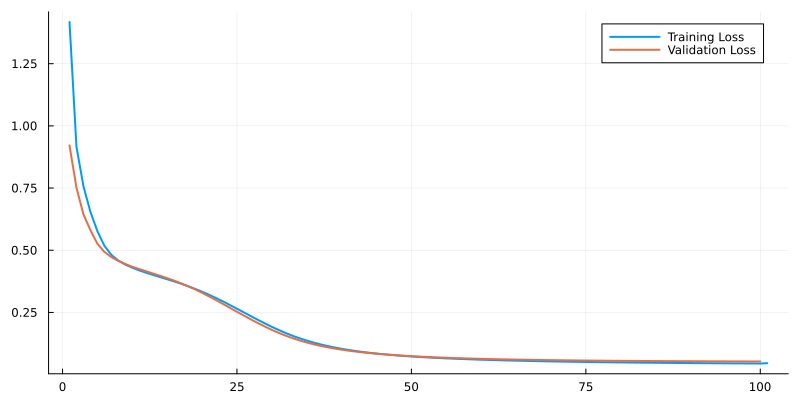

In [9]:
plot(training_losses, label="Training Loss", linewidth=2)
plot!(validation_losses, label="Validation Loss", linewidth=2, size=(800,400))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*